# Pruning input parameters of the Hidden Representation of BERT Model to train a Probing Classifier

# Installing / Importing necessary Packages and Modules

In [ ]:
# First install some extra packages
! pip install pyconll
! pip install transformers
! pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from torch.utils.data import DataLoader
import torch.utils.data as utils

import POStools 


In [3]:
from POStools import Sentence

# collect_pieces function takes tokenized text as input and returns the a tuple of each word of a sentence with it's corresponding index in that sentence

# get_states function takes in the text from Train/Validation/Test set and the BERT model imported from Transformers package and the BERT layer we need the Embeddings/ Representations of the input text. 

# pos_to_ix function takes in tag as input and converts into corresponding index.

# read_conllu function takes in the Path where the UB Tree data input data set is located, the size of the dataset to be tokenized and the BERT layer number to get the corresponding Embeddings.

config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
model = BertModel.from_pretrained('bert-base-uncased', config=config)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model.eval()

train_size = 30000
dev_size = 5000
layer = 6
task = 'labels'

path = 'en_ewt-ud-train.conllu'
path_dev = 'en_ewt-ud-dev.conllu' 
path_test = 'en_ewt-ud-test.conllu'

'''
collect_pieces function takes tokenized text as input 
and returns the a tuple of each word of a sentence with 
it's corresponding index in that sentence

'''

def collect_pieces(tokenized_text):
    output = []
    curr_token = []

    seq_length = len(tokenized_text)
    for i in range(seq_length):
        curr_piece = tokenized_text[i]
        curr_token.append((i, curr_piece))

        if i < seq_length-1:
            next_piece = tokenized_text[i+1]
            if not next_piece.startswith('##'):
                output.append(curr_token)
                curr_token = []

    output.append(curr_token)
    return output




def get_states(text, model, layer_index=1):
    config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
    model = BertModel.from_pretrained('bert-base-uncased', config=config)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_basic_tokenize=True)
    tokenized_text = tokenizer.tokenize(text)
    
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])

    model.eval()
    with torch.no_grad():
        outputs = model(tokens_tensor)
        # 11th BERT layer
        target_layer = outputs[2][11]
        #hidden_states = outputs[2]
        #concat last four layers
        #target_layer = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1)

    collected_pieces = collect_pieces(tokenized_text)
    token_states = []
    for t in collected_pieces:
        token_index = t[-1][0]  # taking last word piece
        token_states.append(target_layer[0, token_index])
    return token_states[1:len(token_states)]
    
    
def pos_to_ix(tag):
    tags = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
    tag_to_ix = dict(zip(tags, list(range(len(tags)))))
    tag_index = tag_to_ix[tag]
    return torch.tensor(tag_index, dtype=torch.long)

def read_conllu(path, train_size, layer):
    with open(path, 'r',encoding='utf-8') as file:
        file = [next(file) for x in range(train_size)]
        sentences = []
        words = []
        pos = []
        tokens = [] 
        for line in file:
            if line == '\n':
                text = '[CLS]' + ' '.join(tokens) + '[SEP]'
                #print(pos)
                sentences.append(Sentence(tokens, pos, get_states(text, model, layer_index=layer)))
                words.extend(get_states(text, model, layer_index=1))  
                assert len(tokens) == len(pos)
                pos = []
                tokens = []
                continue
            if line[0] == '#':
                continue       
            line = line.rstrip('\n')
            line = line.split('\t')
            symbols = ['.', ',', '<', '>', ':' , ';', '\'', '/', '-', '_','%', '@', '#', '$', '^', '*', '?', '!', "‘", "’", "'", "+", '=', '|', '\’']
            if len(line[1]) > 1:
                for sym in symbols: 
                    line[1] = line[1].replace(sym, '')
            if line[1] == '':
                line[1] = 'unk'
            tokens.append(line[1])
            pos.append(line[3])
        

        return sentences


sentences = read_conllu(path, train_size, layer)
sentences_val = read_conllu(path_dev, dev_size, layer)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [168]:
# split_sent_X_Y function splits the sentence class into corresponding X and Y values.

def split_sent_X_Y(sentence):
    X= []
    y = []
    for s in sentence:
        if len(s.pos) == len(s.states[:-1]):
            X.extend(s.states[:-1])
        for tag in s.pos:
            y.append(pos_to_ix(tag))
    
    return X,y


X_train,y_train = split_sent_X_Y(sentences)
X_val,y_val = split_sent_X_Y(sentences_val)



In [169]:
# pos_data function takes in input X and Y from previous function and 
# unsqueezes into 1D so that each token is 768 vectored value.

def pos_data(X, y):
    with torch.no_grad():
        X_new = []
        y_new = []
        tensX = torch.Tensor(len(X), 768)
        tensy = torch.LongTensor(len(y), 1)
        
        for item in X:
            X_new.append(item.unsqueeze(dim=0))
        for item in y:
            y_new.append(item.unsqueeze(dim=0))

        torch.cat(X_new, out=tensX)
        torch.cat(y_new, out=tensy)
        return tensX, tensy

X_train, y_train = pos_data(X_train, y_train)
X_val, y_val = pos_data(X_val, y_val)

In [82]:
def accuracy(X,y,model):
    correct = 0
    total = 0
    for state, target in zip(X, y): 
        outputs = model(state)
        max_value = torch.max(outputs.data)
        pred = (outputs.data == max_value).nonzero()
        total += 1
        correct += (pred == target).sum().item()
    return(100 * correct / total)

Text(0, 0.5, 'Cumulative explained variance')

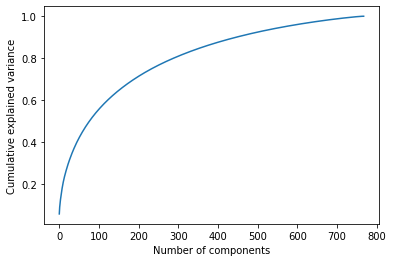

In [83]:
# PCA Variance Explainantion

scaler = StandardScaler()
scaler.fit(X_train)
pca = PCA(n_components=768)
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0, 0.5, 'Cumulative explained variance')

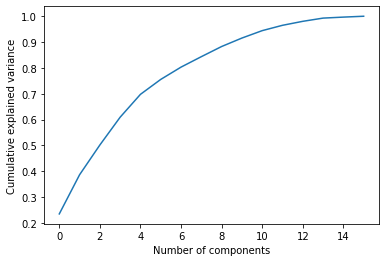

In [84]:
# LDA Variance Explaination

scaler.fit(X_train)
lda = LDA()
lda.fit(X_train, y_train)
LDA(n_components=768, priors=None, shrinkage="auto", solver='svd',
  store_covariance=False, tol=0.0001)
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


In [85]:
def RandomDrop(ip_array,per_drop):
    ind = np.random.choice(np.arange(ip_array.shape[1]), replace=False,
                           size=int(ip_array.shape[1] * per_drop))
    ip_array[ind] = 0
    return torch.tensor(ip_array.astype(np.float32))


In [86]:
def PartialDrop(ip_array,per_drop):
    leng = int((1-per_drop) * ip_array.shape[1])
    op_array = np.zeros((ip_array.shape[0],ip_array.shape[1]))
    for i in range(ip_array.shape[0]):
        op_array[i,:leng] = ip_array[i,:leng]
    return torch.tensor(op_array.astype(np.float32))

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import random

def dim_red_meth(X,y,X_val,y_val,type,per_drop = 0.5,n_comp = 16):
    if type == "PCA":
        
    # PCA for Train data
        scaler = StandardScaler()
        scaler.fit(X)
        leng = int(X.shape[1] * (1 - per_drop))
        pca = PCA(n_components=leng)
        Xpca = pca.fit_transform(X,y)

    # PCA for Val data
        scaler.transform(X_val)
    #pca = PCA(n_components=len)
        Xvalpca = pca.transform(X_val)

    # Convert to Tensors
        Xpca = Xpca.astype(np.float32)
        Xvalpca = Xvalpca.astype(np.float32)
        Xpca = torch.tensor(Xpca)
        Xvalpca = torch.tensor(Xvalpca)

        return(Xpca,Xvalpca)

    elif type == "LDA":
    # LDA for Train data
        sc = StandardScaler()
        Xlda = sc.fit_transform(X)
        lda = LDA(n_components = n_comp)
        Xlda = lda.fit_transform(Xlda, y)

    

    # LDA for Val data
        Xvallda = sc.transform(X_val)
        Xvallda = lda.transform(Xvallda)


    # Converting to Float 32 and tensor
        Xlda = Xlda.astype(np.float32)
        Xvallda = Xvallda.astype(np.float32)
        Xlda = torch.tensor(Xlda)
        Xvallda = torch.tensor(Xvallda)

        return(Xlda,Xvallda)

    elif type == "Partial Drop":
        Xtrain = PartialDrop(X.numpy(),per_drop)
        Xval = PartialDrop(X_val.numpy(),per_drop)

        return(Xtrain,Xval)

    elif type == "Random Drop":
        Xtrain = RandomDrop(X.numpy(),per_drop)
        Xval = RandomDrop(X_val.numpy(),per_drop)

        return (Xtrain,Xval)




    



# Training the model

Function **eval_model** trains the custom model built and evaluates it on Validation / Test data and outputs the Accuracies of both Train and Validation / Test data.

In [88]:
#global_model = None

from POStools import WS,ProbingModule

def eval_model(Xtrain, y_train,Xval, y_val,p):
    

  #global global_model
# Training and Evaulating on Validation data
    evaluator_saver = []
  

    dset = utils.TensorDataset(Xtrain, y_train)
    data_train_loader = DataLoader(dset, batch_size=32, shuffle=False)
    
    torch.manual_seed(42)
  #print(Xtrain.shape[1]) 
    model = ProbingModule(input_dim = Xtrain.shape[1],hidden_dim = 32, output_dim = 17,p = p)
  #global_model = modelPM
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
    evaluator = WS(model)
    n_steps = 0
    train_acc = []
    val_acc = []

    for epoch in range(15):
        for _, (state , target) in enumerate(data_train_loader):
            optimizer.zero_grad()
            tag_score = model(state)
            loss = criterion(tag_score, target)
            loss.backward()
            optimizer.step()

            if n_steps in evaluator.steps:
                #print("n_steps: {0}, accuracy: {1} ".format(n_steps, evaluator.accuracy(Xval, y_val)))
                n_steps += 32

        with torch.no_grad():
            #print("Epoch: {0}, Loss {1}, Acc Train: {2}, Acc Val: {3}".format(epoch,loss, accuracy(Xtrain,y_train,model), accuracy(Xval, y_val,model)) )
            train_acc.append(accuracy(Xtrain,y_train,model))
            val_acc.append(accuracy(Xval, y_val,model))
        #print('WS: {}'.format(evaluator.calc_ws()))
        evaluator_saver.append(evaluator)

  #modelPM.train()
    return(train_acc,val_acc)
#evaluator.plot_accs()

Dimensionality Reduction method is **PCA**

* Model 1

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Number of Parameters considered is 0.75 * 768 = 576, 
   Dropout = 0**
   
   
   
* Model 2

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Number of Parameters considered is 0.85 * 768 = 652, 
   Dropout = 0**
   
   
   
* Model 3

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels,
   Number of Parameters considered is 0.75 * 768 = 729, 
   Dropout = 0**
   

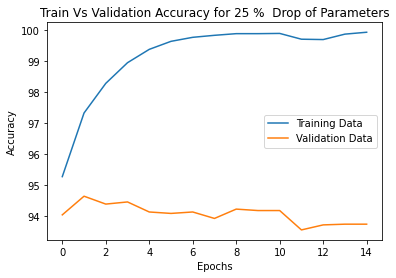

In [89]:

Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'PCA',per_drop = 0.25)

# Train and Evaluating the model
train_acc1,val_acc1 = eval_model(Xtrain, y_train,Xval, y_val,p=0)


plt.plot(np.arange(15),train_acc1,label = "Training Data")
plt.plot(np.arange(15),val_acc1, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


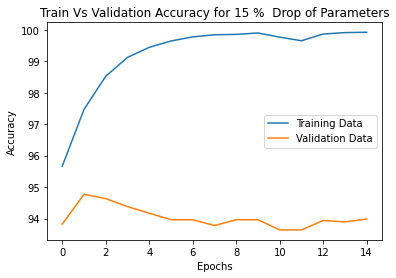

In [90]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'PCA',per_drop = 0.15)

train_acc2,val_acc2 = eval_model(Xtrain, y_train,Xval, y_val,p=0)
plt.plot(np.arange(15),train_acc2,label = "Training Data")
plt.plot(np.arange(15),val_acc2, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

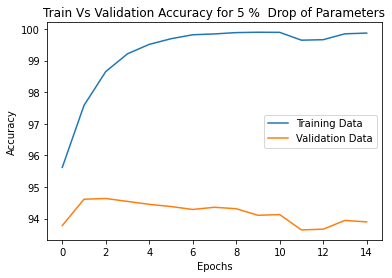

In [91]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'PCA',per_drop = 0.05)

train_acc3,val_acc3 = eval_model(Xtrain, y_train,Xval, y_val,p=0)
plt.plot(np.arange(15),train_acc3,label = "Training Data")
plt.plot(np.arange(15),val_acc3, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Dimensionality Reduction method is **Partial Drop**

* Model 4

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Number of Parameters considered is 0.75 * 768 = 576 and rest is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 5

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Number of Parameters considered is 0.85 * 768 = 652 and rest is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 6

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Number of Parameters considered is 0.75 * 768 = 729 and rest is set to 0, 
   Dropout = 0.5**
   

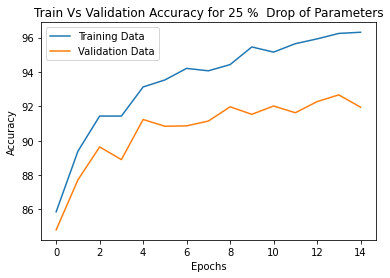

In [92]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'Partial Drop',per_drop = 0.25)

train_acc4,val_acc4 = eval_model(Xtrain, y_train,Xval, y_val,p=0.5)
plt.plot(np.arange(15),train_acc4,label = "Training Data")
plt.plot(np.arange(15),val_acc4, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


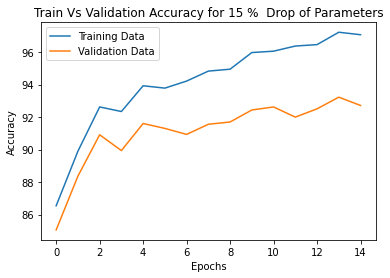

In [93]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'Partial Drop',per_drop = 0.15)

train_acc5,val_acc5 = eval_model(Xtrain, y_train,Xval, y_val,p=0.5)
plt.plot(np.arange(15),train_acc5,label = "Training Data")
plt.plot(np.arange(15),val_acc5, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


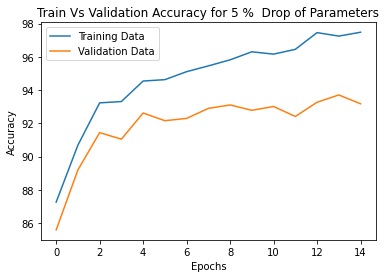

In [94]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'Partial Drop',per_drop = 0.05)

train_acc6,val_acc6 = eval_model(Xtrain, y_train,Xval, y_val,p=0.5)
plt.plot(np.arange(15),train_acc6,label = "Training Data")
plt.plot(np.arange(15),val_acc6, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Dimensionality Reduction method is **LDA**

* Model 7

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Number of Parameters considered is 16 out of 768(after compression), 
   Dropout = 0**
   
   
   
* Model 8

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Number of Parameters considered is 10 out of 768(after compression), 
   Dropout = 0**
   
   

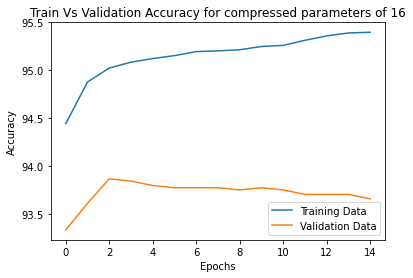

In [95]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'LDA')

train_acc7,val_acc7 = eval_model(Xtrain, y_train,Xval, y_val,p=0)
plt.plot(np.arange(15),train_acc7,label = "Training Data")
plt.plot(np.arange(15),val_acc7, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for compressed parameters of 16")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

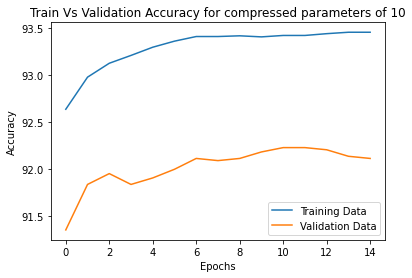

In [96]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'LDA',n_comp=10)

train_acc8,val_acc8 = eval_model(Xtrain, y_train,Xval, y_val,p=0)
plt.plot(np.arange(15),train_acc8,label = "Training Data")
plt.plot(np.arange(15),val_acc8, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for compressed parameters of 10")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

* Model 9

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   All 768 Original Parameters are Considered, 
   Dropout = 0.5**

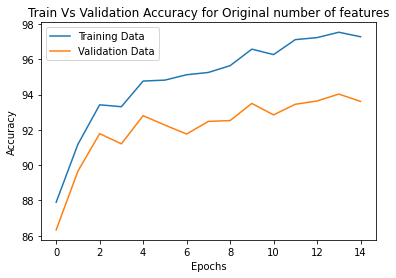

In [97]:
# Original all features

train_acc9,val_acc9 = eval_model(X_train, y_train,X_val, y_val,p=0.5)
plt.plot(np.arange(15),train_acc9,label = "Training Data")
plt.plot(np.arange(15),val_acc9, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for Original number of features")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Dimensionality Reduction method is **Random Drop**

* Model 10

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Randomly 0.25 * 768 parameters is set to 0,  
   Dropout = 0.5**
   
   
   
* Model 11

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Randomly 0.15 * 768 parameters is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 12

   **Xtrain = 26268 tokens(1226 sentences), 
   Ytrain = 26268 Labels, 
   Randomly 0.05 * 768 parameters is set to 0, 
   Dropout = 0.5**
   

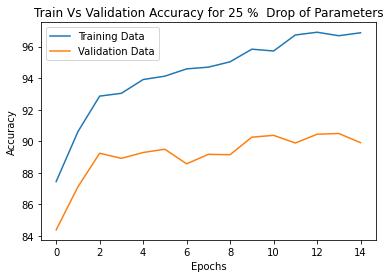

In [98]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'Random Drop',per_drop = 0.25)

train_accRD1,val_accRD1 = eval_model(Xtrain, y_train,Xval, y_val,p=0.5)
plt.plot(np.arange(15),train_accRD1,label = "Training Data")
plt.plot(np.arange(15),val_accRD1, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

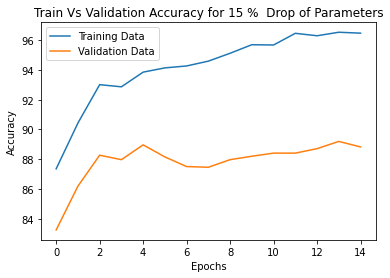

In [99]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'Random Drop',per_drop = 0.15)

train_accRD2,val_accRD2 = eval_model(Xtrain, y_train,Xval, y_val,p=0.5)
plt.plot(np.arange(15),train_accRD2,label = "Training Data")
plt.plot(np.arange(15),val_accRD2, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

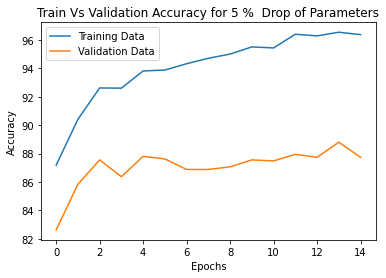

In [100]:
Xtrain,Xval = dim_red_meth(X_train,y_train,X_val,y_val,type = 'Random Drop',per_drop = 0.05)

train_accRD3,val_accRD3 = eval_model(Xtrain, y_train,Xval, y_val,p=0.5)
plt.plot(np.arange(15),train_accRD3,label = "Training Data")
plt.plot(np.arange(15),val_accRD3, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [101]:
#! pip install "nbformat <5"

In [102]:
X_train1,y_train1 = split_sent_X_Y(sentences[:900])
X_val1,y_val1 = split_sent_X_Y(sentences_val[:150])


In [103]:
X_train1, y_train1 = pos_data(X_train1, y_train1)
X_val1, y_val1 = pos_data(X_val1, y_val1)

Dimensionality Reduction method is **PCA**

* Model 1

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels, 
   Number of Parameters considered is 0.75 * 768 = 576, 
   Dropout = 0**
   
   
   
* Model 2

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels, 
   Number of Parameters considered is 0.85 * 768 = 652, 
   Dropout = 0**
   
   
   
* Model 3

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,
   Number of Parameters considered is 0.75 * 768 = 729, 
   Dropout = 0**
   

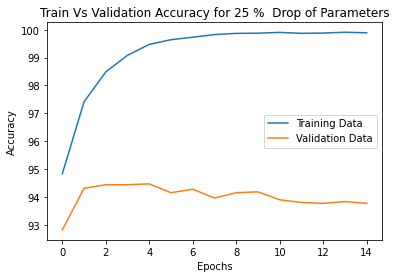

In [104]:
# PCA

Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'PCA',per_drop = 0.25)

# Train and Evaluating the model
train_acc11,val_acc11 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)


plt.plot(np.arange(15),train_acc11,label = "Training Data")
plt.plot(np.arange(15),val_acc11, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


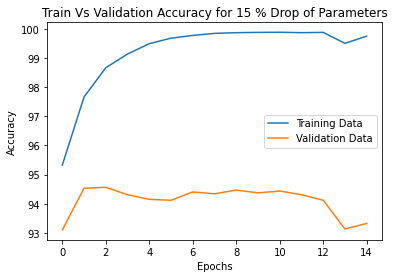

In [105]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'PCA',per_drop = 0.15)

train_acc22,val_acc22 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc22,label = "Training Data")
plt.plot(np.arange(15),val_acc22, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

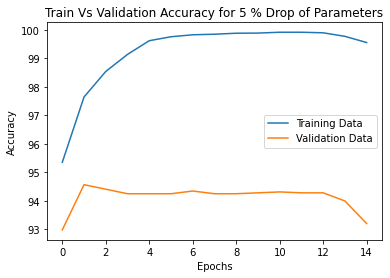

In [106]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'PCA',per_drop = 0.05)

train_acc33,val_acc33 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc33,label = "Training Data")
plt.plot(np.arange(15),val_acc33, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Dimensionality Reduction method is **Partial Drop**

* Model 4

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,
   Number of Parameters considered is 0.75 * 768 = 576 and rest is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 5

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,
   Number of Parameters considered is 0.85 * 768 = 652 and rest is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 6

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,
   Number of Parameters considered is 0.75 * 768 = 729 and rest is set to 0, 
   Dropout = 0.5**
   

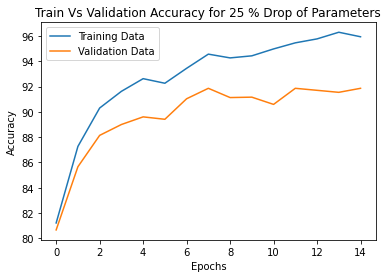

In [107]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Partial Drop',per_drop = 0.25)

train_acc44,val_acc44 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_acc44,label = "Training Data")
plt.plot(np.arange(15),val_acc44, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


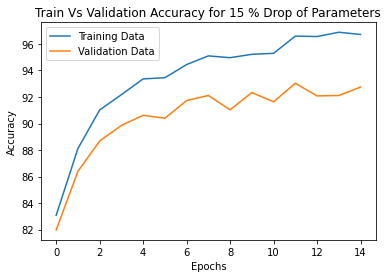

In [108]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Partial Drop',per_drop = 0.15)

train_acc55,val_acc55 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_acc55,label = "Training Data")
plt.plot(np.arange(15),val_acc55, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


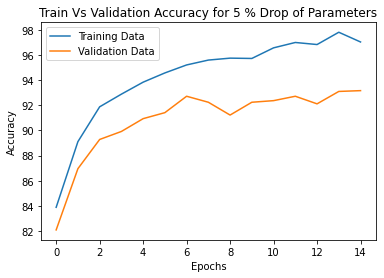

In [109]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Partial Drop',per_drop = 0.05)

train_acc66,val_acc66 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_acc66,label = "Training Data")
plt.plot(np.arange(15),val_acc66, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Dimensionality Reduction method is **LDA**

* Model 7

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,
   Number of Parameters considered is 16 out of 768(after compression), 
   Dropout = 0**
   
   
   
* Model 8

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,
   Number of Parameters considered is 10 out of 768(after compression), 
   Dropout = 0**
   
   

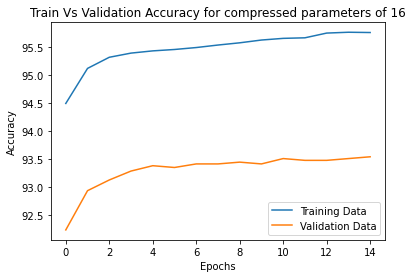

In [110]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'LDA')

train_acc77,val_acc77 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc77,label = "Training Data")
plt.plot(np.arange(15),val_acc77, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for compressed parameters of 16")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

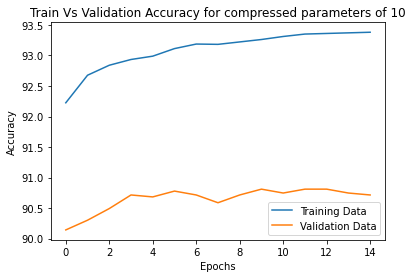

In [111]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'LDA',n_comp=10)

train_acc88,val_acc88 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc88,label = "Training Data")
plt.plot(np.arange(15),val_acc88, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for compressed parameters of 10")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

* Model 9

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,
   All 768 Original Parameters are Considered, 
   Dropout = 0.5**

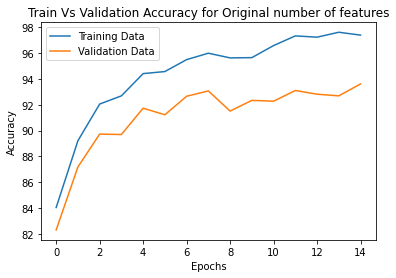

In [112]:
# Original all features

train_acc99,val_acc99 = eval_model(X_train1, y_train1,X_val1, y_val1,p=0.5)
plt.plot(np.arange(15),train_acc99,label = "Training Data")
plt.plot(np.arange(15),val_acc99, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for Original number of features")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Dimensionality Reduction method is **Random Drop**

* Model 10

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,  
   Randomly 0.25 * 768 parameters is set to 0,  
   Dropout = 0.5**
   
   
   
* Model 11

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,  
   Randomly 0.15 * 768 parameters is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 12

   **Xtrain = 20168 tokens(900 sentences), 
   Ytrain = 20168 Labels,  
   Randomly 0.05 * 768 parameters is set to 0, 
   Dropout = 0.5**
   

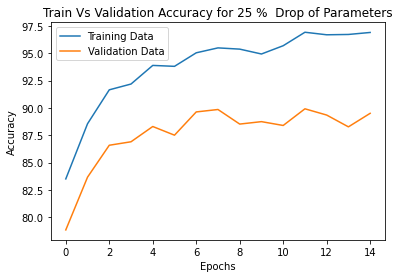

In [113]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Random Drop',per_drop = 0.25)

train_accRD11,val_accRD11 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_accRD11,label = "Training Data")
plt.plot(np.arange(15),val_accRD11, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

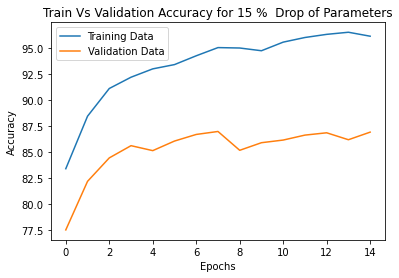

In [114]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Random Drop',per_drop = 0.15)

train_accRD22,val_accRD22 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_accRD22,label = "Training Data")
plt.plot(np.arange(15),val_accRD22, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

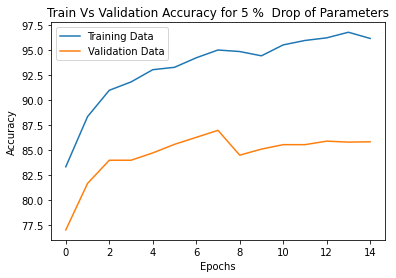

In [115]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Random Drop',per_drop = 0.05)

train_accRD33,val_accRD33 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_accRD33,label = "Training Data")
plt.plot(np.arange(15),val_accRD33, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [116]:
X_train1,y_train1 = split_sent_X_Y(sentences[:500])
X_val1,y_val1 = split_sent_X_Y(sentences_val[:80])



In [117]:
X_train1, y_train1 = pos_data(X_train1, y_train1)
X_val1, y_val1 = pos_data(X_val1, y_val1)

Dimensionality Reduction method is **PCA**

* Model 1

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels, 
   Number of Parameters considered is 0.75 * 768 = 576, 
   Dropout = 0**
   
   
   
* Model 2

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels, 
   Number of Parameters considered is 0.85 * 768 = 652, 
   Dropout = 0**
   
   
   
* Model 3

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,
   Number of Parameters considered is 0.75 * 768 = 729, 
   Dropout = 0**
   

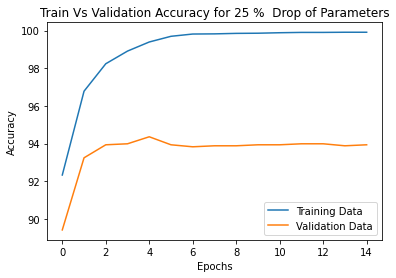

In [118]:
# PCA

Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'PCA',per_drop = 0.25)

# Train and Evaluating the model
train_acc111,val_acc111 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc111,label = "Training Data")
plt.plot(np.arange(15),val_acc111, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


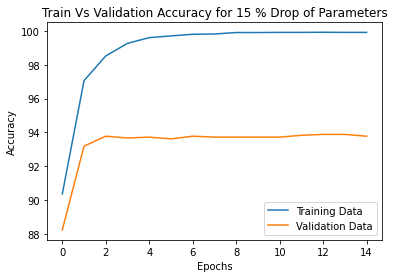

In [119]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'PCA',per_drop = 0.15)

train_acc222,val_acc222 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc222,label = "Training Data")
plt.plot(np.arange(15),val_acc222, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

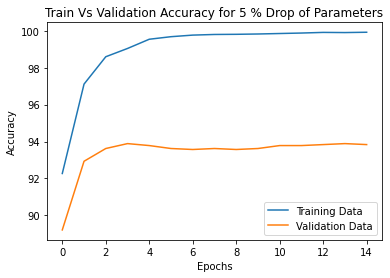

In [120]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'PCA',per_drop = 0.05)

train_acc333,val_acc333 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc333,label = "Training Data")
plt.plot(np.arange(15),val_acc333, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Dimensionality Reduction method is **Partial Drop**

* Model 4

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,
   Number of Parameters considered is 0.75 * 768 = 576 and rest is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 5

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,
   Number of Parameters considered is 0.85 * 768 = 652 and rest is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 6

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,
   Number of Parameters considered is 0.75 * 768 = 729 and rest is set to 0, 
   Dropout = 0.5**
   

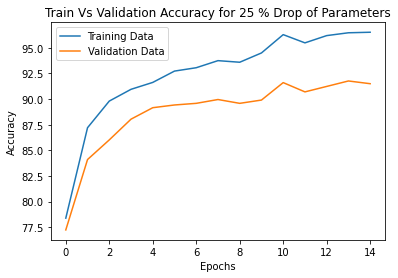

In [121]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Partial Drop',per_drop = 0.25)


train_acc444,val_acc444 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_acc444,label = "Training Data")
plt.plot(np.arange(15),val_acc444, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


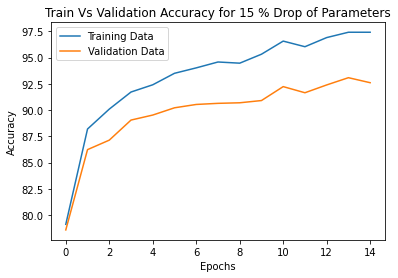

In [122]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Partial Drop',per_drop = 0.15)

train_acc555,val_acc555 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_acc555,label = "Training Data")
plt.plot(np.arange(15),val_acc555, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


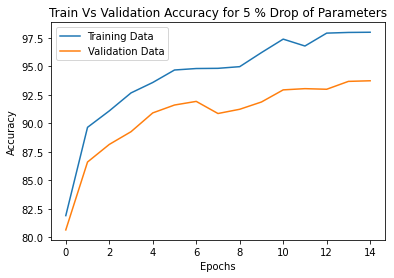

In [123]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Partial Drop',per_drop = 0.05)

train_acc666,val_acc666 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_acc666,label = "Training Data")
plt.plot(np.arange(15),val_acc666, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Dimensionality Reduction method is **LDA**

* Model 7

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,
   Number of Parameters considered is 16 out of 768(after compression), 
   Dropout = 0**
   
   
   
* Model 8

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,
   Number of Parameters considered is 10 out of 768(after compression), 
   Dropout = 0**
   
   

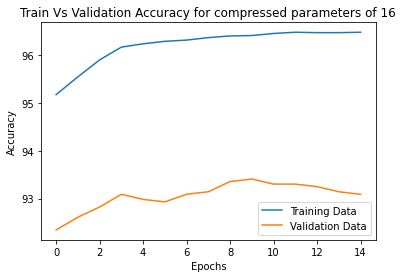

In [124]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'LDA')

train_acc777,val_acc777 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc777,label = "Training Data")
plt.plot(np.arange(15),val_acc777, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for compressed parameters of 16")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

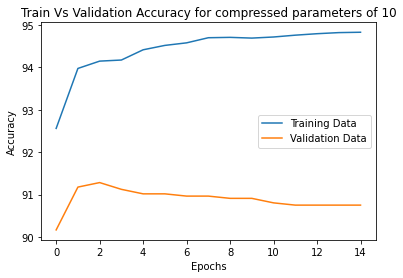

In [125]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'LDA',n_comp=10)

train_acc888,val_acc888 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0)
plt.plot(np.arange(15),train_acc888,label = "Training Data")
plt.plot(np.arange(15),val_acc888, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for compressed parameters of 10")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

* Model 9

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,
   All 768 Original Parameters are Considered, 
   Dropout = 0.5**

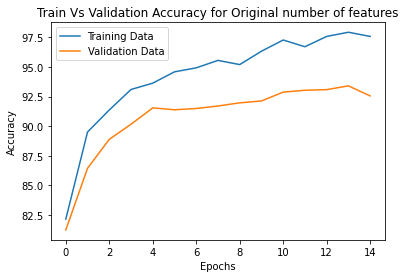

In [126]:
# Original all features

train_acc999,val_acc999 = eval_model(X_train1, y_train1,X_val1, y_val1,p=0.5)
plt.plot(np.arange(15),train_acc999,label = "Training Data")
plt.plot(np.arange(15),val_acc999, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for Original number of features")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Dimensionality Reduction method is **Random Drop**

* Model 10

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,  
   Randomly 0.25 * 768 parameters is set to 0,  
   Dropout = 0.5**
   
   
   
* Model 11

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,  
   Randomly 0.15 * 768 parameters is set to 0, 
   Dropout = 0.5**
   
   
   
* Model 12

   **Xtrain = 11598 tokens(500 sentences), 
   Ytrain = 11598 Labels,  
   Randomly 0.05 * 768 parameters is set to 0, 
   Dropout = 0.5**
   

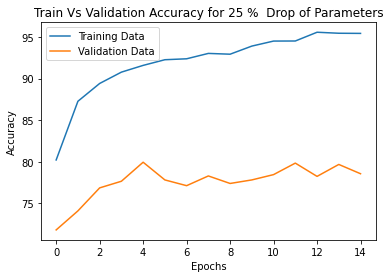

In [128]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Random Drop',per_drop = 0.25)

train_accRD111,val_accRD111 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_accRD111,label = "Training Data")
plt.plot(np.arange(15),val_accRD111, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 25 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

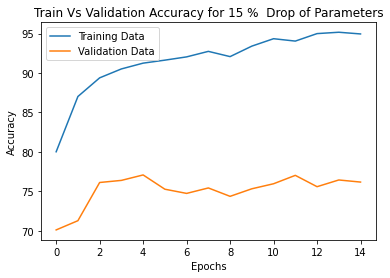

In [129]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Random Drop',per_drop = 0.15)

train_accRD222,val_accRD222 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_accRD222,label = "Training Data")
plt.plot(np.arange(15),val_accRD222, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 15 %  Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

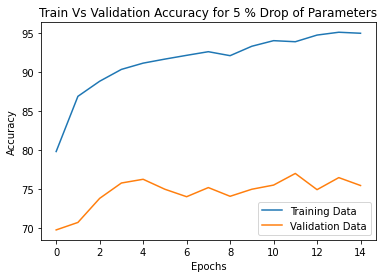

In [130]:
Xtrain,Xval = dim_red_meth(X_train1,y_train1,X_val1,y_val1,type = 'Random Drop',per_drop = 0.05)

train_accRD333,val_accRD333 = eval_model(Xtrain, y_train1,Xval, y_val1,p=0.5)
plt.plot(np.arange(15),train_accRD333,label = "Training Data")
plt.plot(np.arange(15),val_accRD333, label = "Validation Data")
plt.title("Train Vs Validation Accuracy for 5 % Drop of Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

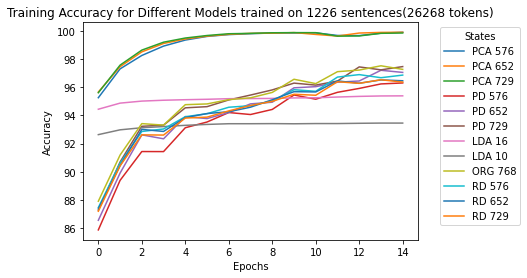

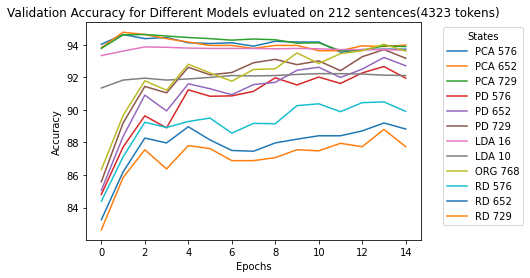

         Train Accuracy  Validation Accuracy
PCA 576       99.920055            93.731205
PCA 652       99.923862            93.985658
PCA 729       99.870565            93.893130
PD 576        96.314908            91.950035
PD 652        97.064870            92.713393
PD 729        97.479823            93.176035
LDA 16        95.397442            93.661809
LDA 10        93.459723            92.111959
ORG 768       97.281864            93.615545
RD 576        96.874524            89.914411
RD 652        96.470991            88.827203
RD 729        96.375818            87.739995


In [137]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
#fontP.set_size('xx-small')

p1, = plt.plot(np.arange(15),train_acc1,label = "PCA 576")
p2, = plt.plot(np.arange(15),train_acc2,label = "PCA 652")
p3, = plt.plot(np.arange(15),train_acc3,label = "PCA 729")
p4, = plt.plot(np.arange(15),train_acc4,label = "PD 576")
p5, = plt.plot(np.arange(15),train_acc5,label = "PD 652")
p6, = plt.plot(np.arange(15),train_acc6,label = "PD 729")
p7, = plt.plot(np.arange(15),train_acc7,label = "LDA 16")
p8, = plt.plot(np.arange(15),train_acc8,label = "LDA 10")
p9, = plt.plot(np.arange(15),train_acc9,label = "ORG 768")
p10, = plt.plot(np.arange(15),train_accRD1,label = "RD 576")
p11, = plt.plot(np.arange(15),train_accRD2,label = "RD 652")
p12, = plt.plot(np.arange(15),train_accRD3,label = "RD 729")
plt.title("Training Accuracy for Different Models trained on 1226 sentences(26268 tokens)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(handles=[p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12], title='States', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()


p1, =  plt.plot(np.arange(15),val_acc1, label = "PCA 576")
p2, =  plt.plot(np.arange(15),val_acc2, label = "PCA 652")
p3, =  plt.plot(np.arange(15),val_acc3, label = "PCA 729")
p4, =  plt.plot(np.arange(15),val_acc4, label = "PD 576")
p5, =  plt.plot(np.arange(15),val_acc5, label = "PD 652")
p6, =  plt.plot(np.arange(15),val_acc6, label = "PD 729")
p7, =  plt.plot(np.arange(15),val_acc7, label = "LDA 16")
p8, =  plt.plot(np.arange(15),val_acc8, label = "LDA 10")
p9, =  plt.plot(np.arange(15),val_acc9, label = "ORG 768")
p10, = plt.plot(np.arange(15),val_accRD1,label = "RD 576")
p11, = plt.plot(np.arange(15),val_accRD2,label = "RD 652")
p12, = plt.plot(np.arange(15),val_accRD3,label = "RD 729")
plt.title("Validation Accuracy for Different Models evluated on 212 sentences(4323 tokens)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(handles=[p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12], title='States', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()

import pandas as pd
df1 = pd.DataFrame(columns=['Train Accuracy', 'Validation Accuracy'])
df1['Train Accuracy'] = [train_acc1[-1],train_acc2[-1],train_acc3[-1],train_acc4[-1],train_acc5[-1],train_acc6[-1],train_acc7[-1],train_acc8[-1],train_acc9[-1],train_accRD1[-1],train_accRD2[-1],train_accRD3[-1]]
df1['Validation Accuracy'] = [val_acc1[-1],val_acc2[-1],val_acc3[-1],val_acc4[-1],val_acc5[-1],val_acc6[-1],val_acc7[-1],val_acc8[-1],val_acc9[-1],val_accRD1[-1],val_accRD2[-1],val_accRD3[-1]]
df1.index = ["PCA 576","PCA 652","PCA 729","PD 576","PD 652","PD 729","LDA 16","LDA 10","ORG 768","RD 576","RD 652","RD 729"]
print(df1)


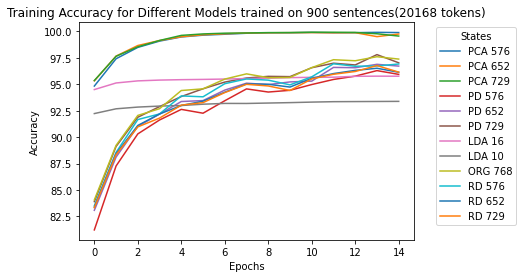

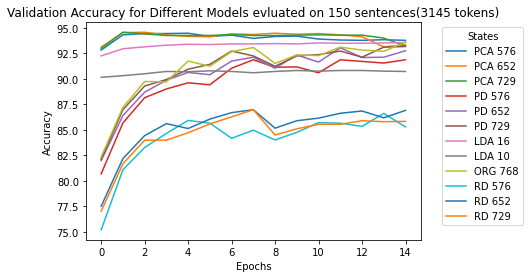

         Train Accuracy  Validation Accuracy
PCA 576       99.890916            93.767886
PCA 652       99.752083            93.322734
PCA 729       99.558707            93.195548
PD 576        95.934153            91.860095
PD 652        96.717572            92.750397
PD 729        97.029948            93.163752
LDA 16        95.760611            93.545310
LDA 10        93.380603            90.715421
ORG 768       97.381991            93.608903
RD 576        96.915906            85.273791
RD 652        96.132487            86.899841
RD 729        96.147362            85.818760


In [138]:
p1, = plt.plot(np.arange(15),train_acc11,label = "PCA 576")
p2, = plt.plot(np.arange(15),train_acc22,label = "PCA 652")
p3, = plt.plot(np.arange(15),train_acc33,label = "PCA 729")
p4, = plt.plot(np.arange(15),train_acc44,label = "PD 576")
p5, = plt.plot(np.arange(15),train_acc55,label = "PD 652")
p6, = plt.plot(np.arange(15),train_acc66,label = "PD 729")
p7, = plt.plot(np.arange(15),train_acc77,label = "LDA 16")
p8, = plt.plot(np.arange(15),train_acc88,label = "LDA 10")
p9, = plt.plot(np.arange(15),train_acc99,label = "ORG 768")
p10, =plt.plot(np.arange(15),train_accRD11,label = "RD 576")
p11, =plt.plot(np.arange(15),train_accRD22,label = "RD 652")
p12, =plt.plot(np.arange(15),train_accRD33,label = "RD 729")
plt.title("Training Accuracy for Different Models trained on 900 sentences(20168 tokens)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(handles=[p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12], title='States', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()


p1, =  plt.plot(np.arange(15),val_acc11, label = "PCA 576")
p2, =  plt.plot(np.arange(15),val_acc22, label = "PCA 652")
p3, =  plt.plot(np.arange(15),val_acc33, label = "PCA 729")
p4, =  plt.plot(np.arange(15),val_acc44, label = "PD 576")
p5, =  plt.plot(np.arange(15),val_acc55, label = "PD 652")
p6, =  plt.plot(np.arange(15),val_acc66, label = "PD 729")
p7, =  plt.plot(np.arange(15),val_acc77, label = "LDA 16")
p8, =  plt.plot(np.arange(15),val_acc88, label = "LDA 10")
p9, =  plt.plot(np.arange(15),val_acc99, label = "ORG 768")
p10, = plt.plot(np.arange(15),val_accRD11,label = "RD 576")
p11, = plt.plot(np.arange(15),val_accRD22,label = "RD 652")
p12, = plt.plot(np.arange(15),val_accRD33,label = "RD 729")
plt.title("Validation Accuracy for Different Models evluated on 150 sentences(3145 tokens)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(handles=[p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12], title='States', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()


df2 = pd.DataFrame(columns=['Train Accuracy', 'Validation Accuracy'])
df2['Train Accuracy'] = [train_acc11[-1],train_acc22[-1],train_acc33[-1],train_acc44[-1],train_acc55[-1],train_acc66[-1],train_acc77[-1],train_acc88[-1],train_acc99[-1],train_accRD11[-1],train_accRD22[-1],train_accRD33[-1]]
df2['Validation Accuracy'] = [val_acc11[-1],val_acc22[-1],val_acc33[-1],val_acc44[-1],val_acc55[-1],val_acc66[-1],val_acc77[-1],val_acc88[-1],val_acc99[-1],val_accRD11[-1],val_accRD22[-1],val_accRD33[-1]]
df2.index = ["PCA 576","PCA 652","PCA 729","PD 576","PD 652","PD 729","LDA 16","LDA 10","ORG 768","RD 576","RD 652","RD 729"]
print(df2)


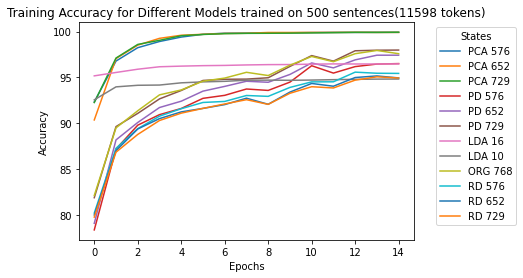

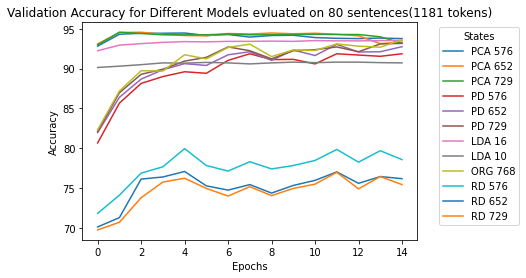

         Train Accuracy  Validation Accuracy
PCA 576       99.913778            93.939394
PCA 652       99.905156            93.779904
PCA 729       99.922400            93.833068
PD 576        96.508019            91.493886
PD 652        97.421969            92.610314
PD 729        97.982411            93.726741
LDA 16        96.473530            93.088783
LDA 10        94.826694            90.749601
ORG 768       97.585791            92.557150
RD 576        95.438869            78.575226
RD 652        94.947405            76.182881
RD 729        94.938783            75.438596


In [139]:

p1, = plt.plot(np.arange(15),train_acc111,label = "PCA 576")
p2, = plt.plot(np.arange(15),train_acc222,label = "PCA 652")
p3, = plt.plot(np.arange(15),train_acc333,label = "PCA 729")
p4, = plt.plot(np.arange(15),train_acc444,label = "PD 576")
p5, = plt.plot(np.arange(15),train_acc555,label = "PD 652")
p6, = plt.plot(np.arange(15),train_acc666,label = "PD 729")
p7, = plt.plot(np.arange(15),train_acc777,label = "LDA 16")
p8, = plt.plot(np.arange(15),train_acc888,label = "LDA 10")
p9, = plt.plot(np.arange(15),train_acc999,label = "ORG 768")
p10, =plt.plot(np.arange(15),train_accRD111,label = "RD 576")
p11, =plt.plot(np.arange(15),train_accRD222,label = "RD 652")
p12, =plt.plot(np.arange(15),train_accRD333,label = "RD 729")
plt.title("Training Accuracy for Different Models trained on 500 sentences(11598 tokens)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(handles=[p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12], title='States', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()


p1, =  plt.plot(np.arange(15),val_acc11, label = "PCA 576")
p2, =  plt.plot(np.arange(15),val_acc22, label = "PCA 652")
p3, =  plt.plot(np.arange(15),val_acc33, label = "PCA 729")
p4, =  plt.plot(np.arange(15),val_acc44, label = "PD 576")
p5, =  plt.plot(np.arange(15),val_acc55, label = "PD 652")
p6, =  plt.plot(np.arange(15),val_acc66, label = "PD 729")
p7, =  plt.plot(np.arange(15),val_acc77, label = "LDA 16")
p8, =  plt.plot(np.arange(15),val_acc88, label = "LDA 10")
p9, =  plt.plot(np.arange(15),val_acc99, label = "ORG 768")
p10, = plt.plot(np.arange(15),val_accRD111,label = "RD 576")
p11, = plt.plot(np.arange(15),val_accRD222,label = "RD 652")
p12, = plt.plot(np.arange(15),val_accRD333,label = "RD 729")
plt.title("Validation Accuracy for Different Models evluated on 80 sentences(1181 tokens)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(handles=[p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12], title='States', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()


df3 = pd.DataFrame(columns=['Train Accuracy', 'Validation Accuracy'])
df3['Train Accuracy'] = [train_acc111[-1],train_acc222[-1],train_acc333[-1],train_acc444[-1],train_acc555[-1],train_acc666[-1],train_acc777[-1],train_acc888[-1],train_acc999[-1],train_accRD111[-1],train_accRD222[-1],train_accRD333[-1]]
df3['Validation Accuracy'] = [val_acc111[-1],val_acc222[-1],val_acc333[-1],val_acc444[-1],val_acc555[-1],val_acc666[-1],val_acc777[-1],val_acc888[-1],val_acc999[-1],val_accRD111[-1],val_accRD222[-1],val_accRD333[-1]]
df3.index = ["PCA 576","PCA 652","PCA 729","PD 576","PD 652","PD 729","LDA 16","LDA 10","ORG 768","RD 576","RD 652","RD 729"]
print(df3)


In [145]:
def accuracy_cust(X,y,model):
    correct = 0
    total = 0
    pred_lis = []
    for state, target in zip(X, y): 
        outputs = model(state)
        max_value = torch.max(outputs.data)
        pred = (outputs.data == max_value).nonzero()
        #print(f"Iteration,{total}, Pred , {pred}")
        pred_lis.append(int(pred))
        total += 1
        correct += (pred == target).sum().item()
    acc = 100 * correct / total
    return acc,pred_lis

In [162]:
#global_model = None

from POStools import WS,ProbingModule

def eval_model_cust(Xtrain, y_train,Xval, y_val,p):
    

  #global global_model
# Training and Evaulating on Validation data
    evaluator_saver = []
  

    dset = utils.TensorDataset(Xtrain, y_train)
    data_train_loader = DataLoader(dset, batch_size=32, shuffle=False)
    
    torch.manual_seed(42)
  #print(Xtrain.shape[1]) 
    model = ProbingModule(input_dim = Xtrain.shape[1],hidden_dim = 32, output_dim = 17,p = p)
  #global_model = modelPM
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
    evaluator = WS(model)
    n_steps = 0
    train_acc = []
    val_acc = []
    val_pred = []

    for epoch in range(5):
        for _, (state , target) in enumerate(data_train_loader):
            optimizer.zero_grad()
            tag_score = model(state)
            loss = criterion(tag_score, target)
            loss.backward()
            optimizer.step()

            if n_steps in evaluator.steps:
                #print("n_steps: {0}, accuracy: {1} ".format(n_steps, evaluator.accuracy(Xval, y_val)))
                n_steps += 32

        with torch.no_grad():
            #print("Epoch: {0}, Loss {1}, Acc Train: {2}, Acc Val: {3}".format(epoch,loss, accuracy(Xtrain,y_train,model), accuracy(Xval, y_val,model)) )
            vl_acc,vl_pred = accuracy_cust(Xval, y_val,model)
            val_acc.append(vl_acc)
            val_pred.append(vl_pred)
        #print('WS: {}'.format(evaluator.calc_ws()))
        evaluator_saver.append(evaluator)

  #modelPM.train()
    return(train_acc,val_acc,val_pred)
#evaluator.plot_accs()

In [170]:
Xtrain1,Xval1 = dim_red_meth(X_train,y_train,X_val,y_val,type = 'PCA',per_drop = 0.25)

Xtrain2,Xval2 = dim_red_meth(X_train,y_train,X_val,y_val,type = 'Partial Drop',per_drop = 0.25)

Xtrain3,Xval3 = dim_red_meth(X_train,y_train,X_val,y_val,type = 'LDA')

Xtrain4,Xval4 = dim_red_meth(X_train,y_train,X_val,y_val,type = 'Random Drop',per_drop = 0.25)


# Train and Evaluating the model

train_acc1,val_acc1,valPred1 = eval_model_cust(Xtrain1, y_train,Xval1[:10], y_val[:10],p=0)

train_acc2,val_acc2,valPred2 = eval_model_cust(Xtrain2, y_train,Xval2[:10], y_val[:10],p=0)

train_acc3,val_acc3,valPred3 = eval_model_cust(Xtrain3, y_train,Xval3[:10], y_val[:10],p=0)

train_acc4,val_acc4,valPred4 = eval_model_cust(Xtrain3, y_train,Xval3[:10], y_val[:10],p=0)

In [158]:
def op_comparison(valpred):
    df1 = pd.DataFrame(columns=['Ep1','Ep2','Ep3','Ep4','Ep5','OrgLabel'])
    for i in range(5):
        df1[str("Ep")+str(i+1)] = valpred[i]
    df1['OrgLabel'] = y_val[:10]
    return df1

In [171]:
df_PCA = op_comparison(valPred1)
print("An example of output label after each epoch using Latent Feature Representation of PCA from Original BERT Representation:\n")
print(df_PCA)
df_PartialDrop = op_comparison(valPred2)
print("\n An example of output label after each epoch using Partial Drop Feature Representation from Original BERT Representation:\n")
print(df_PartialDrop)
df_LDA = op_comparison(valPred3)
print("\n An example of output label after each epoch using Latent Feature Representation of LDA from Original BERT Representation:\n")
print(df_LDA)
df_RandomDrop = op_comparison(valPred4)
print("\n An example of output label after each epoch using Random Drop Feature Representation from Original BERT Representation:\n")
print(df_RandomDrop)

An example of output label after each epoch using Latent Feature Representation of PCA from Original BERT Representation:

   Ep1  Ep2  Ep3  Ep4  Ep5  OrgLabel
0    1    1    1    1    1         1
1    5    5    5    5    5         5
2   11   11   11   11   11        11
3   15   15   15   15   15        15
4    5    5    5    5    5         5
5    7    7    7    7    7         7
6   12   12   12   12   12        12
7   11   11   11   11   11        11
8   11   11   11   11   11        11
9    1   15   15   15   15         1

 An example of output label after each epoch using Partial Drop Feature Representation from Original BERT Representation:

   Ep1  Ep2  Ep3  Ep4  Ep5  OrgLabel
0    1    1    1    1    1         1
1    5    5    5    5    5         5
2   11   11   11   11   11        11
3   15   15   15   15   15        15
4    5    5    5    5    5         5
5    7    7    7    7    7         7
6   12   12   12   12   12        12
7   11   11   11   11   11        11
8   11   11  